## Environment Set Up

To build a functional application, we'll need to use several libraries/frameworks. To do this, we'll set up an environment that contains everything we need. We'll be using the conda package manager for this.

You can easily replicate the environment with a .yml file. Download it and place it in the directory of your future project. Then, from that same project directory, run the following command in the command line:
```
conda env create -f environment.yml
```
Setting up the environment might take some time.

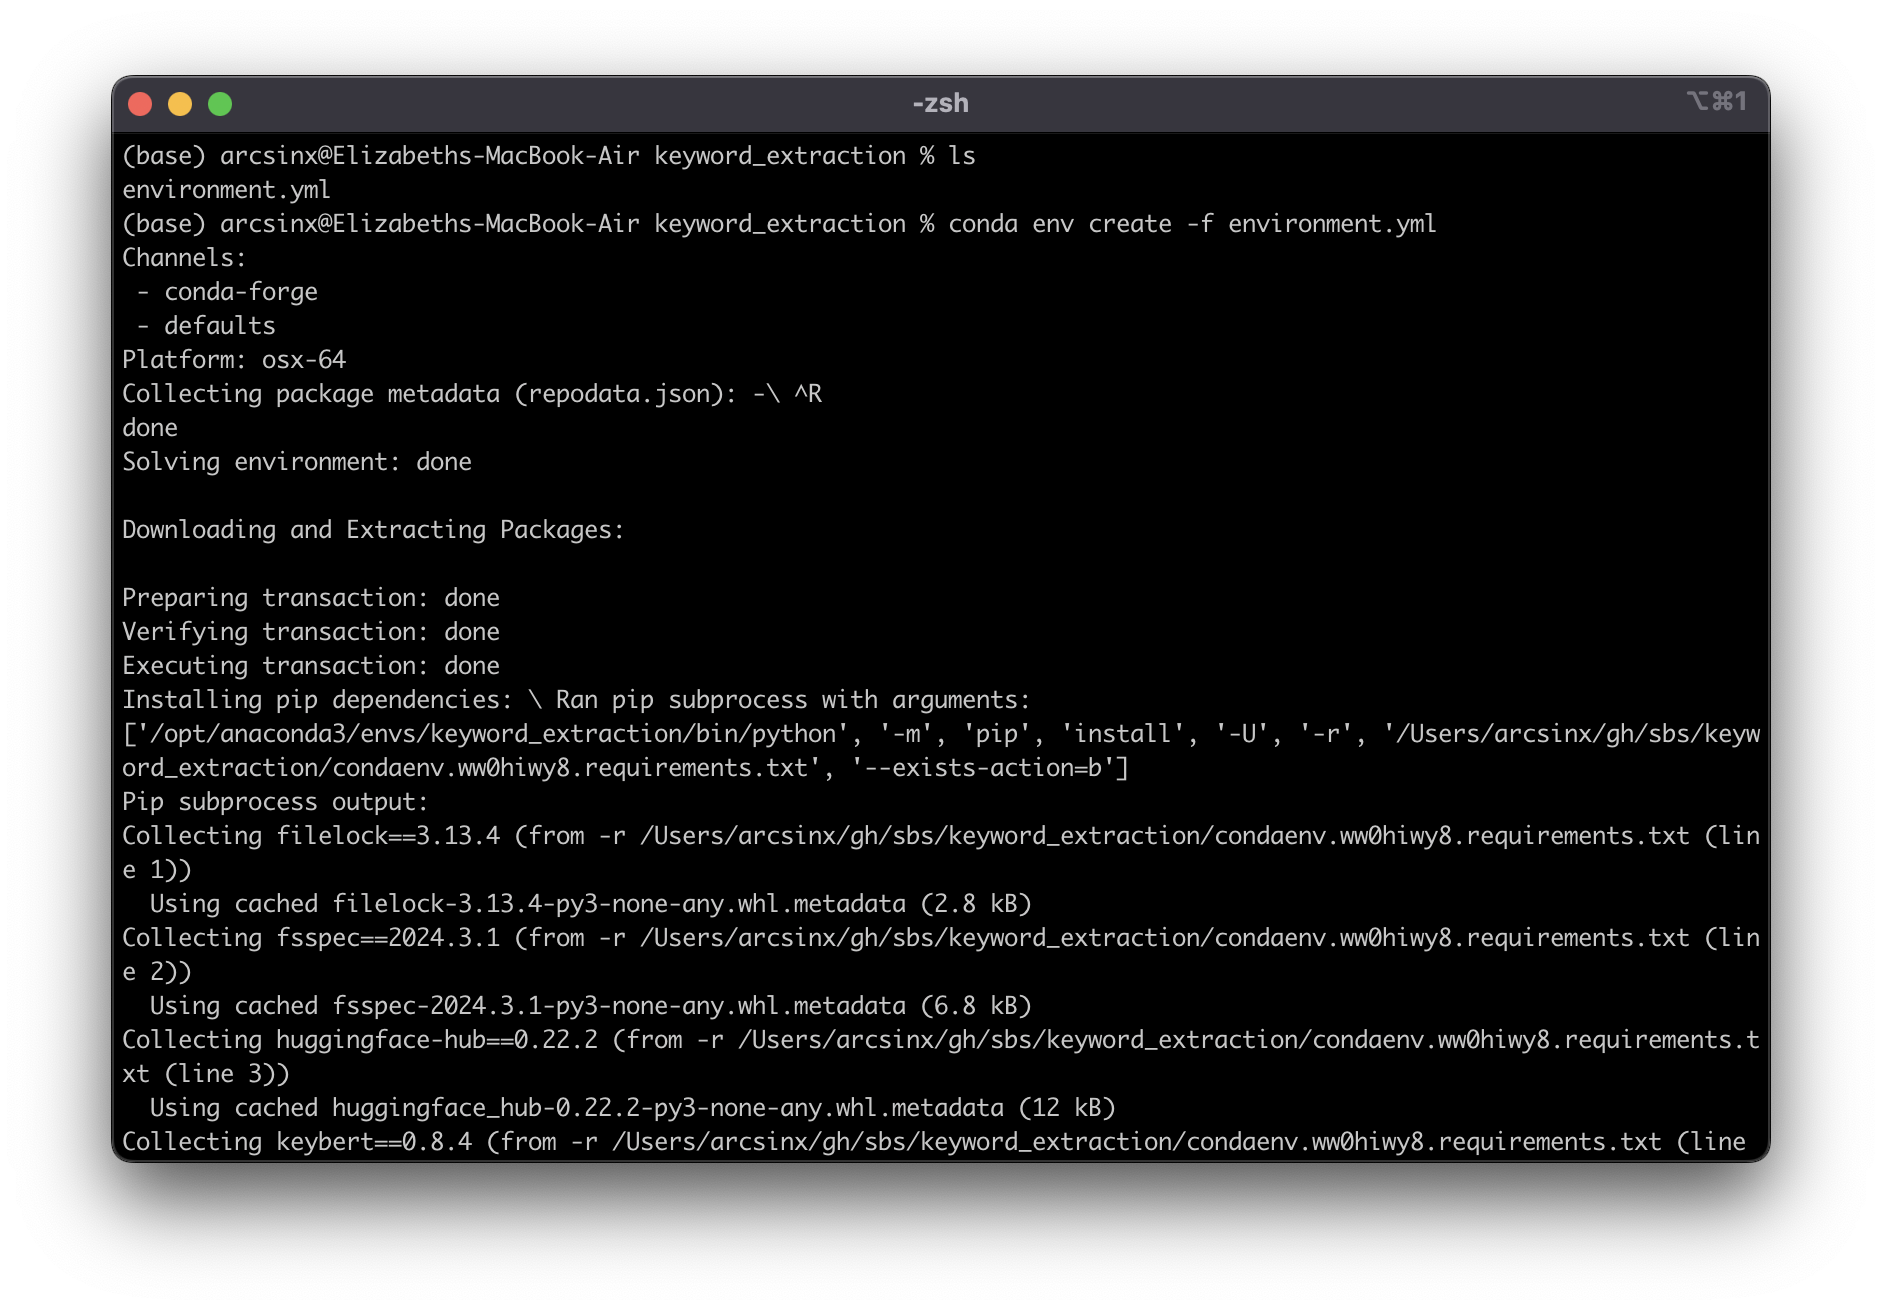

This environment includes Python, nltk, Flask, keyBert, and libraries for processing PDFs and other text file formats. Once you've created the environment, you need to activate it:
```
conda activate nlp
```
Now you have everything you need to get to work. Remember to deactivate the environment when you're done using this command:
```
conda deactivate nlp
```

## Flask

Now that you've prepared and activated your environment, you can start building a Flask application. We'll start with the simplest setup and gradually complicate the code. Flask is a micro-framework for Python web applications, providing the necessary tools for quick web application development.

## Minimal Flask Application

1. Create a file for your application \
   Create a file named app.py in the code directory of your project. This file will contain all the backend code in Python.

2. Let's create the simplest application possible:
   In app.py, copy and paste this code:
   ```
   from flask import Flask
   app = Flask(__name__)
    
   @app.route('/')
   def upload_file():
       return "Hey there!"
 
   if __name__ == '__main__':
       app.run(debug=True)
   ```
    \
   Let's break down what's happening here. We import the Flask class from the flask module and then create an instance of this class called app. This instance will handle requests and send responses as our web application. \
   \
   The decorator @app.route('/') designates a URL that will call the upload_file() function. When you access the root of your site, Flask invokes upload_file(), which returns the string "Hey there!"

4. Running the application: \
   Run app.py using Python. The application will be hosted locally on port 5000. You can access your application in a web browser at http://127.0.0.1:5000/

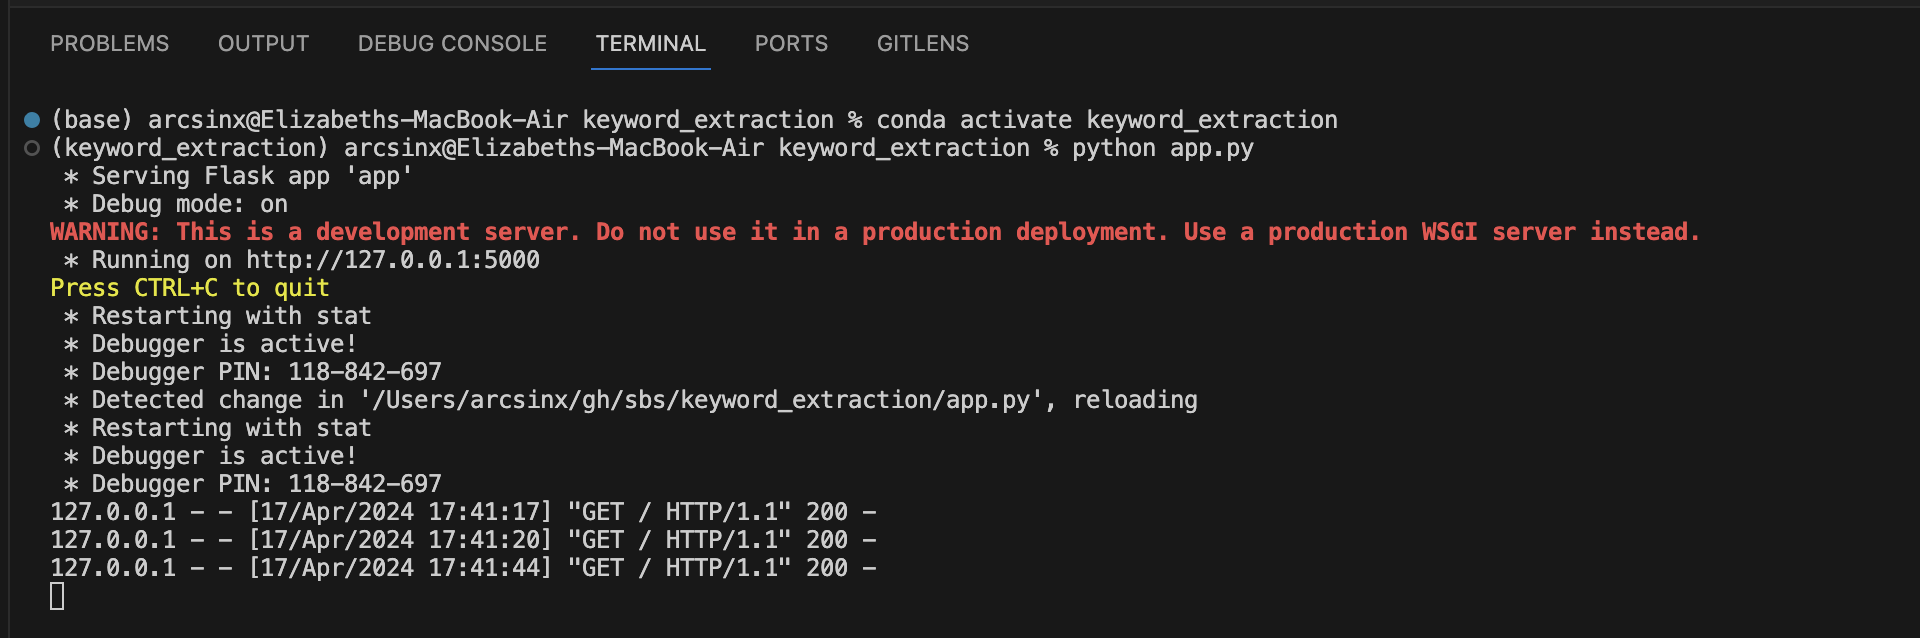


## Logging

One best practice I recommend following is incorporating logging into our application. Logging enables us to monitor all events and keep track of what is happening within the application. With logging, you'll find it easier to determine at which stage a problem arises and spend less time resolving it.

To add logging, we use the logging module.

```logging.basicConfig``` configures the logging levels and format. We set the level to ```DEBUG```, which means all levels (DEBUG, INFO, WARNING, ERROR, CRITICAL) will be logged. We'll record these logs in the file ```app.log.```.

```
import logging

logging.basicConfig(level=logging.DEBUG, filename='app.log', filemode='w',
                    format='%(name)s - %(levelname)s - %(message)s')
```
Now, let's add ```logging.info('Home page accessed')``` to the home() function:
```
@app.route('/')
def home():
    logging.info('Home page accessed')
    return "Hey there!"
```

Every time this function is called, a log entry stating "Home page accessed" will be recorded in the log file. You can place such checkpoints in your functions as desired.

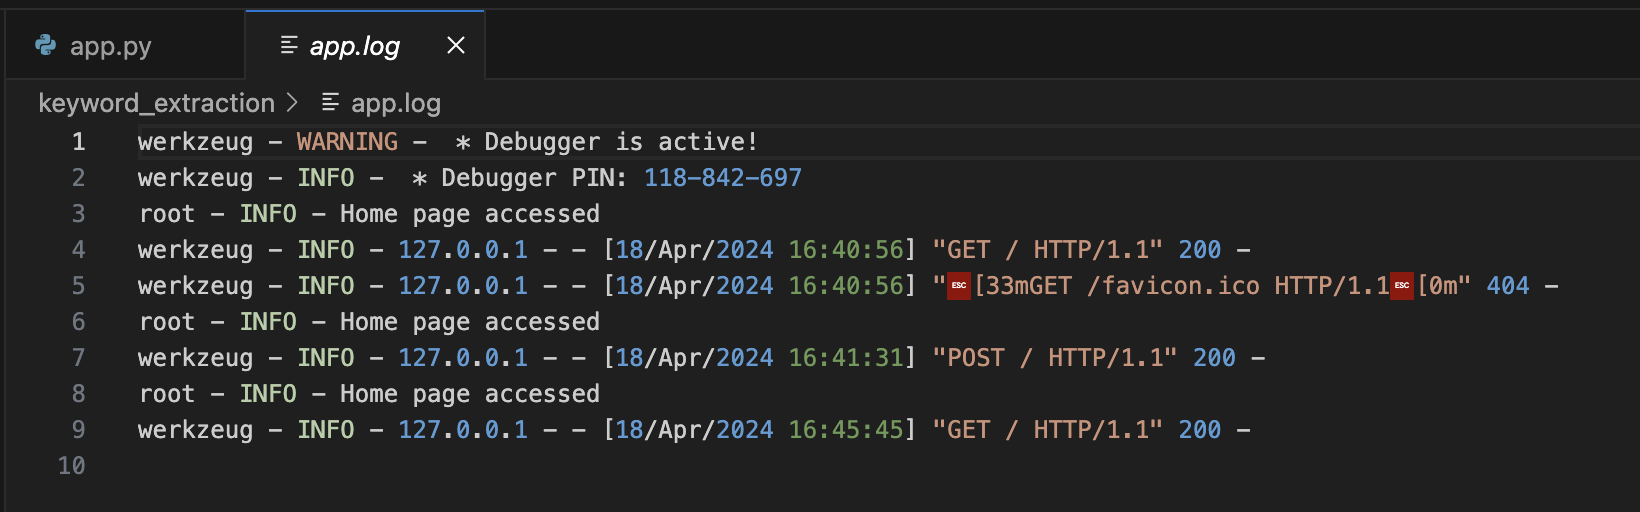

## HTML and getting user input via form

Flask can render HTML templates and handle form data, allowing users to interact with your application through web forms.
Adding a Simple HTML Template

First, create a directory named templates in the same folder as your script. Inside this directory, create a file named home.html:
```
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Submit Text</title>
</head>
<body>
    <form action="/" method="post">
        <input type="text" name="text" placeholder="Enter text here">
        <input type="submit" value="Submit">
    </form>
</body>
</html>
```

This HTML form sends a POST request to the server with the input text when the submit button is clicked. \

Сейчас мы напишем функцию, которая будет возвращать зеркальное отображение введенной пользователем строки. Мы так же добавим в основную функцию редер шаблона, фласк сам созьмет шаблон из папки с шаблонами.
```
from flask import Flask, render_template, request
```

```
def process_text(text):
    return text[::-1]
```

```
@app.route('/', methods=['GET', 'POST'])
def home():
    if request.method == 'POST':
        user_input = request.form['text']
        processed_text = process_text(user_input)
        return processed_text
    return render_template('home.html')
```

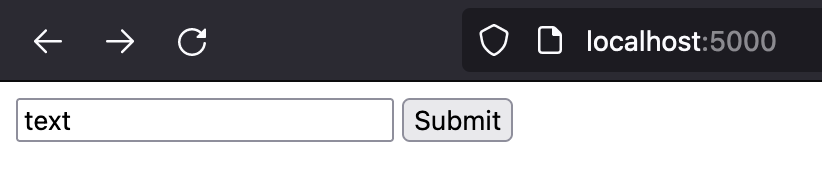

Введите любой текст в форму и посмотрите, что получится. Функция должна работать корректно, после отправки формы страница обновится и вы увидите зеркальное отображение введенного текста.

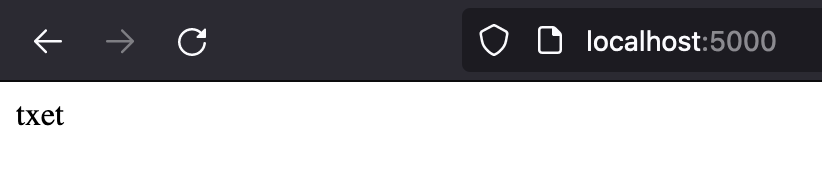

## File Upload

We also want to enable users to upload files in PDF, DOC, and TXT formats. To do this, we need to add a file search button to the interface and a function in the backend code that uploads the file to a specified location.

Let's start by modifying the HTML template:
```
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Submit Text or Upload File</title>
</head>
<body>
    <form action="/" method="post" enctype="multipart/form-data">
        <h2>Submit Text or Upload File</h2>
        <p>You can either enter text, upload a file, or do both.</p>

        <!-- Section for text input -->
        <label for="text">Enter text:</label>
        <input type="text" id="text" name="text" placeholder="Enter text here">
        <br><br>

        <!-- Section for file upload -->
        <label for="file">Choose a file:</label>
        <input type="file" id="file" name="file">
        <br><br>

        <!-- Submit button -->
        <input type="submit" value="Submit">
    </form>
</body>
</html>

```

Next, we'll set the directory where we will save the files using app.config. Create this directory in the code directory of your project:

```
app.config['UPLOAD_FOLDER'] = 'uploads'
```

We'll also set the supported file extensions to prevent users from uploading, for example, an image or something else:
```
app.config['ALLOWED_EXTENSIONS'] = {'pdf', 'docx', 'txt'}
```

Write a simple function to check if the file extension matches our list:
```
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in app.config['ALLOWED_EXTENSIONS']
```

Now we need to make changes in the code. The ```upload_file()``` function orchestrates the upload process:

1. It checks if the request method is ```POST```, which is typical for forms that send data.
2. If a file is present and has a non-empty filename, it checks the file type with ```allowed_file()```. If valid, it saves the file using a secure filename to the specified upload folder and logs this event.
3. If the file type is not allowed, or if no file is provided and no text is entered, it provides feedback to the user through flash messages and redirects to the form page.
4. For text inputs, the text is processed (assuming a function ```process_text()``` exists for handling or analyzing the text), and this processing is logged.
5. After processing, the function either displays processed text directly or informs the user about the status of their upload, such as where the file was saved.
    
```
def upload_file():
    if request.method == 'POST':
        file = request.files.get('file')
        text = request.form.get('text')

        if file and file.filename != '':
            if allowed_file(file.filename):
                filename = secure_filename(file.filename)
                file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
                file.save(file_path)
                logging.info(f'File saved to {file_path}')
                processed_text = f'File saved to {file_path}'
            else:
                flash('File type is not allowed.')
                return redirect(request.url)
        elif text:
            processed_text = process_text(text)
            logging.info('Text data processed.')
        else:
            flash('No file or text provided!')
            return redirect(request.url)

        return processed_text

    return render_template('upload_page.html')
```

Restart your app.py app and open the same address in the browser. 

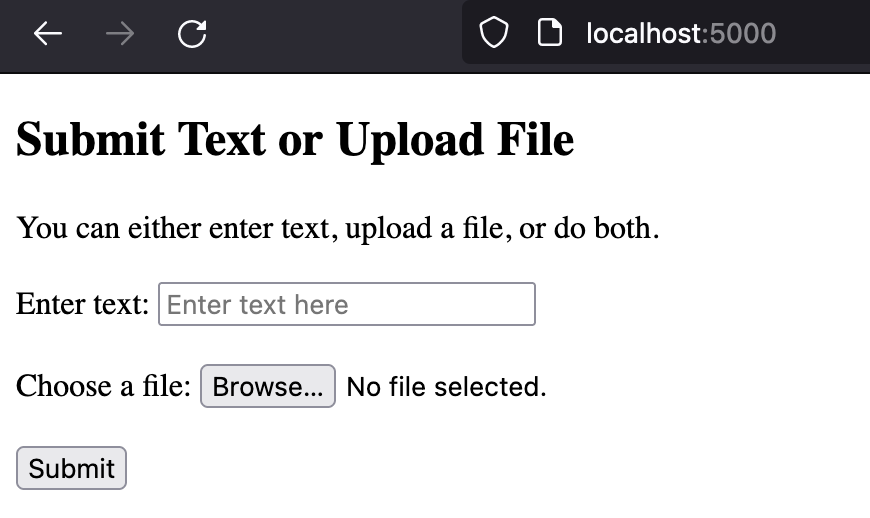

## Reading Text from Uploaded Files

Now we extend our Flask application to extract text from uploaded files, processing them just as we do text input from the form. This unified approach allows us to handle various file types, such as PDF, DOCX, and TXT.
1. Let's import the required modules:

   ```
   import PyPDF2
   from docx import Document
   ```
\
3. And define text extraction functions.\
    This function opens the PDF in binary mode, reads each page, extracts the text, and combines it into a single string:
```
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, "rb") as file:
        reader = PyPDF2.PdfReader(file)
        text = [page.extract_text() for page in reader.pages]
    return ' '.join(text)
```

This function reads a DOCX file and compile all paragraph texts into one continuous string:
    
```
def extract_text_from_docx(docx_path):
    doc = Document(docx_path)
    return ' '.join([para.text for para in doc.paragraphs])
```

And the last function is straightforward — it reads and returns the entire content of a TXT file:

```
def extract_text_from_txt(txt_path):
    with open(txt_path, 'r') as file:
        return file.read()
```

Modify the File Upload Route

Incorporate the file reading functionality into the upload_file route to handle both text and file uploads:

```
extension = filename.rsplit('.', 1)[1].lower()
    if extension == 'pdf':
        extracted_text = extract_text_from_pdf(file_path)
    elif extension == 'docx':
        extracted_text = extract_text_from_docx(file_path)
    elif extension == 'txt':
        extracted_text = extract_text_from_txt(file_path)
```

## Creating a Simple Result Page

After handling and processing the uploaded files or text input from the form, we need a way to present the results to the user. In this step, we will create a simple HTML result page that displays the processed text. This step is essential as it provides immediate feedback to the user about the operation they performed.

Create the HTML Template for Results

We'll create a new HTML file named result.html in the templates folder. This template will display the processed text that our Flask app sends after handling the user's input or file upload.

Create a new file result.html with the following content:
```
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Processing Results</title>
</head>
<body>
    <h1>Result of Your Submission</h1>
    <p>The processed text is:</p>
    <div style="border:1px solid black; padding:10px; width:600px; margin-top:10px;">
        {{ processed_text }}
    </div>
    <a href="/">Submit another</a>
</body>
</html>
```
Integrate the Result Page in the Flask Route

Now, we need to ensure that our Flask route renders this new template with the appropriate data after processing the text or file input. This involves modifying the upload_file() function to use the render_template() function with result.html as the target template and passing the processed_text variable to it.

Here's the relevant part of the upload_file() function:
```
return render_template('result.html', processed_text=processed_text)
```

## keyBert

Now that we have a fully functional Flask application capable of handling file uploads and displaying results, we will enhance its functionality by integrating KeyBERT for keyword extraction. KeyBERT is a minimal and effective method for extracting keywords using BERT embeddings, providing relevant keywords that can help summarize and index the content.
```
from keybert import KeyBERT
kw_model = KeyBERT()
```
This instance, ```kw_model```, will be used to extract keywords from the text processed by our application.

Modify the Text Processing Function

Now, we need to adapt the ```process_text()``` function to utilize KeyBERT for extracting keywords. Modify the function to take a string of text and return a string of keywords separated by spaces:
```
def process_text(text):
    # KeyBERT's extract_keywords method returns a list of tuples (keyword, score)
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english', highlight=False)
    # We only want the keyword part of each tuple, not the score
    keyword_phrases = [keyword[0] for keyword in keywords]  # Extract just the keywords
    return ' '.join(keyword_phrases)
```

The ```extract_keywords``` method of ```KeyBERT``` is called with the input text. The parameters can be adjusted according to your needs. For instance, ```keyphrase_ngram_range``` controls the size of the n-grams for the keywords, and ```stop_words='english'``` removes common English stop words to improve relevance.

The method returns a list of keyword-score tuples, but we only extract the keyword part. The keywords are joined into a single string separated by spaces, making it easy to display on our result page.

Use Processed Text in Your Application

With ```process_text()``` now using KeyBERT, every time text is processed (whether it comes from a file or direct input), it will be processed to extract keywords. The final string of keywords is what will be passed to the result page for display:

```
if file and file.filename != '':
    ...
    processed_text = process_text(extracted_text)
elif text:
    processed_text = process_text(text)
...
return render_template('result.html', processed_text=processed_text)
```

## Bootstrap украшательства

Bootstrap and custom CSS will enhance the user interface, making it visually appealing and user-friendly. Below, we'll break down the key elements of the HTML and CSS and suggest how you can customize them to fit your style preferences.

https://getbootstrap.com/docs/5.3/examples/

### Key HTML and CSS Features

1. **Bootstrap Integration**:
    - We use Bootstrap 4.5.2, which simplifies the creation of a responsive and modern interface. Bootstrap's classes are used throughout the HTML to style forms, buttons, and other elements consistently.

2. **Responsive Meta Tag**:
    - `<meta name="viewport" content="width=device-width, initial-scale=1.0">` ensures that the layout is responsive and scales properly on different devices.

3. **External Fonts**:
    - Google Fonts (Roboto) is incorporated to enhance typography, giving the page a sleek and readable font.

### Detailed CSS Breakdown

- **General Styling**:
    - The `body` and `html` tags are styled to use the full height of the viewport, centered content, and a light grey background that is easy on the eyes.
    - The `container` class adds a shadow, white background, rounded borders, and padding, creating a distinct area for user interactions.

- **Header and Descriptions**:
    - The `.header` class styles the title area with a blue background and white text, drawing immediate attention.
    - The `.description` class uses a smaller font size and a lighter text color for supplementary information, keeping it visually subordinate to more important elements.

- **Form Input and Button Styling**:
    - Form inputs and buttons are styled for consistency and ease of use. They are wider than the default Bootstrap styling to enhance accessibility and aesthetics.
    - The `.btn-file` inside the `.form-file` changes the traditional file input into a more appealing button that reveals the file input when clicked.

### Customizing the Style

To tailor the page to your preferences, consider the following modifications:

- **Color Scheme**:
    - Change the `background-color` properties to match your brand or desired palette. For instance, adjust the `.header` and button colors to create a different visual impact.
  
- **Font and Text**:
    - Modify the `font-family` in the body or specific elements if you prefer a different typography style.
    - Adjust `font-size` and `color` in classes like `.description` to fine-tune the readability and tone of the text.

- **Layout Adjustments**:
    - Alter the `width`, `margin`, and `padding` properties to increase or decrease the spacing and sizing of elements according to your layout needs.
    - Use Bootstrap's grid system to add more complex layouts or responsive features.

- **Additional Elements**:
    - Incorporate more interactive elements like modals, tooltips, or collapsible panels using Bootstrap's JavaScript plugins.
    - Enhance accessibility by adding `aria` attributes and focusing on keyboard navigability.

### Copy the HTML Page

Feel free to copy the HTML provided and paste it into your project. Remember to keep the links to Bootstrap and jQuery, as they are essential for ensuring that the Bootstrap features function correctly.